In [1]:
import os          
import cv2
import netron
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from matplotlib import pyplot
from datetime import datetime      
import matplotlib.pyplot as plt 
from ann_visualizer.visualize import ann_viz
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as model_selection

%load_ext tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [2]:
def load_data(dataset):
    class_names = []
    images = []
    labels = []  
    for folder in os.listdir(dataset):
        class_names.append(folder)    
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)} 
    print("Loading Dataset {}".format(dataset))
    for folder in os.listdir(dataset):
        label = class_names_label[folder]
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
            img_path = os.path.join(os.path.join(dataset, folder), file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            IMAGE_SIZE = (150, 150)
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
            labels.append(label)
    return images, labels , class_names

In [3]:
dataset = "C:/Users/Karnan/Downloads/dataset/leaves"
images, labels, class_names = load_data(dataset)

Loading Dataset C:/Users/Karnan/Downloads/dataset/leaves


100%|███████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 135.44it/s]


In [4]:
images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32') 

In [5]:
images = images/255.0

In [6]:
train_images, test_images, train_labels, test_labels = model_selection.train_test_split(images, labels, train_size=0.80,test_size=0.20, random_state=101) 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation=tf.nn.softmax)
])

In [8]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(train_images, train_labels, batch_size=128, epochs = 50, validation_split = 0.2,callbacks=[tensorboard_callback])

Epoch 1/50
19/19 [==============================] - 10s 149ms/step - loss: 3.1815 - accuracy: 0.1022 - val_loss: 2.4993 - val_accuracy: 0.2721
Epoch 2/50
19/19 [==============================] - 1s 67ms/step - loss: 1.9015 - accuracy: 0.4378 - val_loss: 1.6755 - val_accuracy: 0.5017
Epoch 3/50
19/19 [==============================] - 1s 68ms/step - loss: 1.2780 - accuracy: 0.6171 - val_loss: 1.3225 - val_accuracy: 0.6224
Epoch 4/50
19/19 [==============================] - 1s 68ms/step - loss: 0.9164 - accuracy: 0.7291 - val_loss: 1.2557 - val_accuracy: 0.6497
Epoch 5/50
19/19 [==============================] - 1s 69ms/step - loss: 0.6724 - accuracy: 0.7951 - val_loss: 1.1473 - val_accuracy: 0.6837
Epoch 6/50
19/19 [==============================] - 1s 68ms/step - loss: 0.4460 - accuracy: 0.8633 - val_loss: 1.1766 - val_accuracy: 0.6905
Epoch 7/50
19/19 [==============================] - 1s 69ms/step - loss: 0.3065 - accuracy: 0.9037 - val_loss: 1.2816 - val_accuracy: 0.7160
Epoch 8/50


In [10]:
model.evaluate(test_images, test_labels)

23/23 [==============================] - 0s 14ms/step - loss: 1.8759 - accuracy: 0.7766


[1.8758801221847534, 0.776566743850708]

In [11]:
def plot_accuracy_loss(history):
    y = ['accuracy','loss']
    for x in y:
        plt.plot(history.history[x],color='orange', label = x )
        plt.plot(history.history['val_'+x], color='lime', label ='val_'+x)
        plt.title("train_"+x + " vs val_"+x)
        plt.ylabel(x)
        plt.xlabel("epochs")
        plt.legend()
        plt.show()

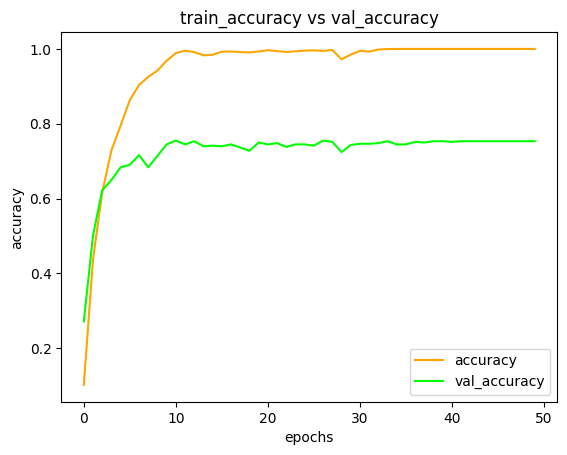

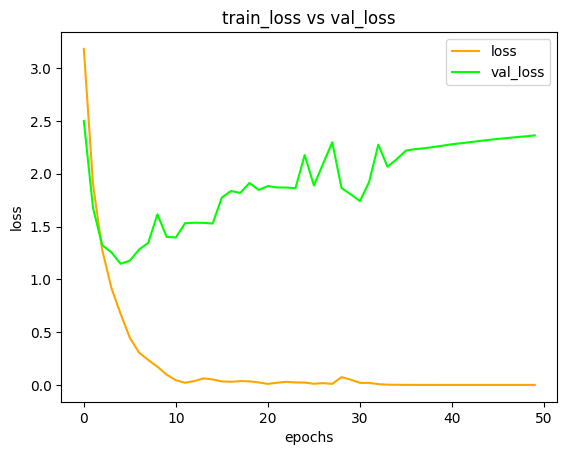

In [12]:
plot_accuracy_loss(history)

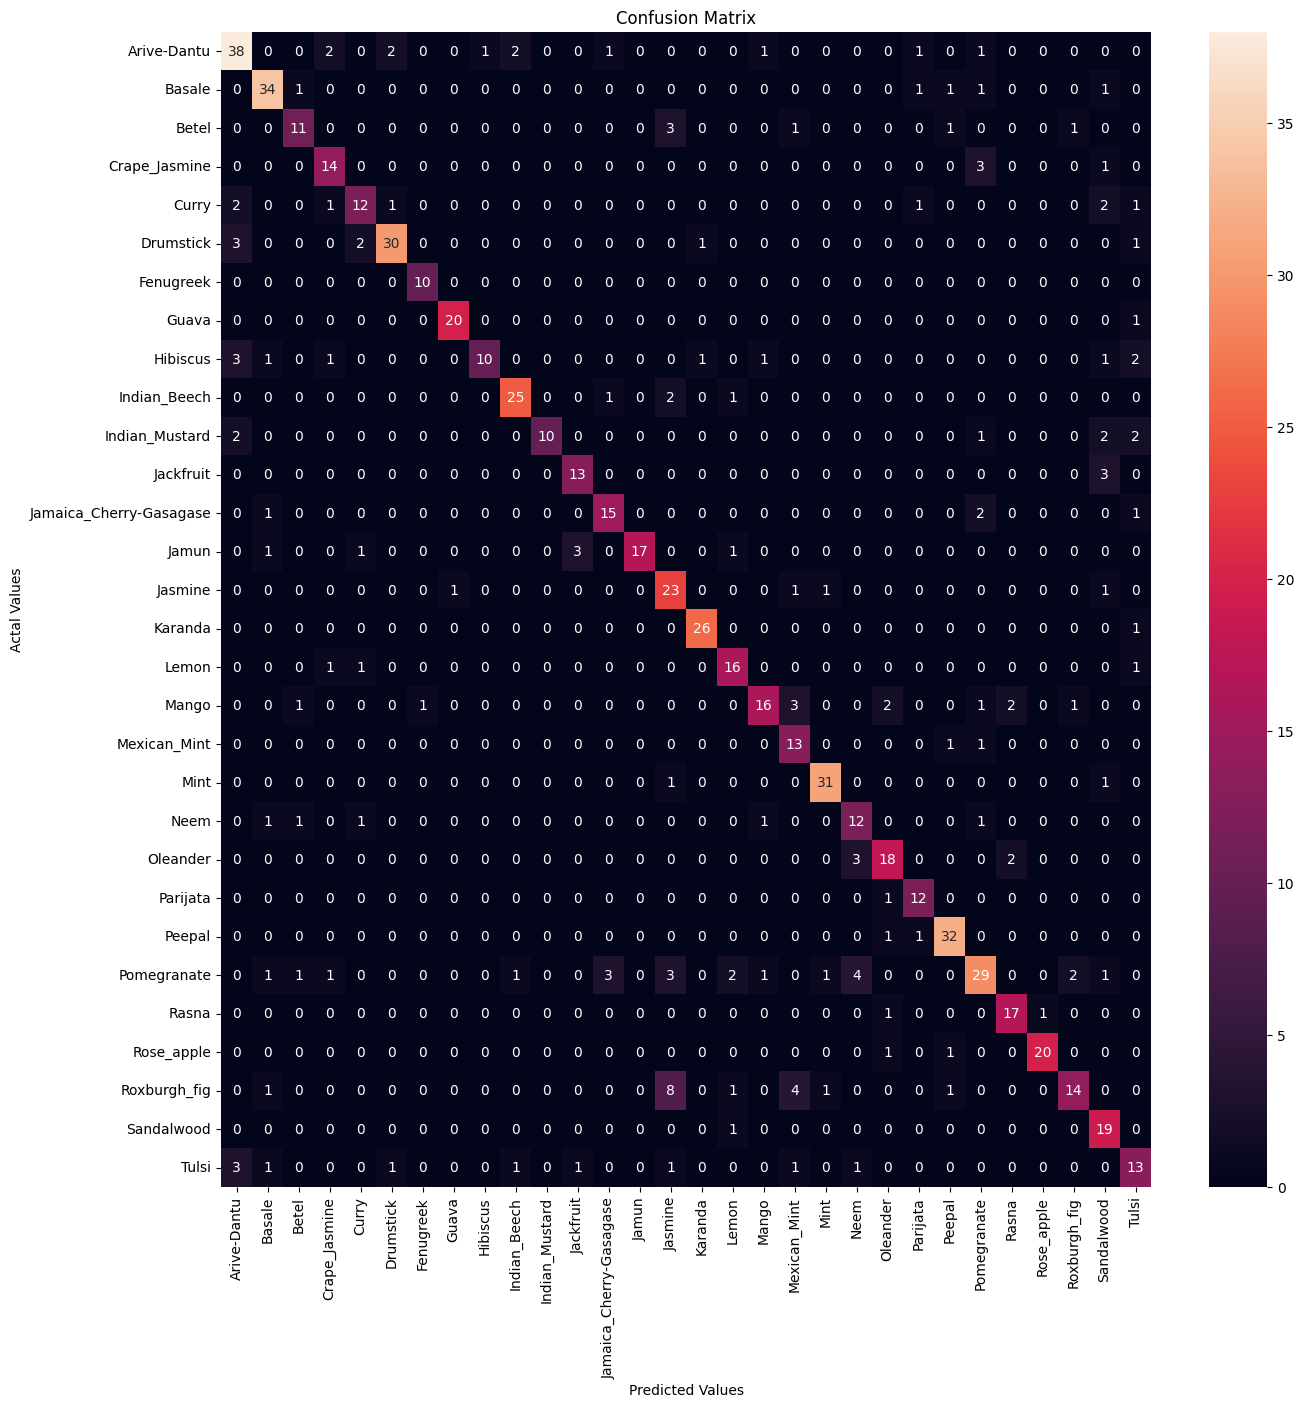

In [22]:
def measures(y_actual, y_pred):
    cnf_matrix = pd.DataFrame(confusion_matrix(actual,predictions),index = class_names, columns =class_names)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN )
    F1_score = (2 * Recall * Precision) / (Recall + Precision)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    Specificity = TP/(TP+FN)
    FNR = FN/(TP+FN)
    FPR = FP/(FP+TN)
        
    dict = {}
    dict['class_name'] = class_names
    dict['TP'] = TP
    dict['FP'] = FP
    dict['TN'] = TN
    dict['FN'] = FN
    dict['Accuracy'] = Accuracy
    dict['Precision'] = Precision
    dict['Recall'] = Recall
    dict['F1_score'] = F1_score
    dict['Error_rate'] = Error_rate
    dict['Specificity'] = Specificity
    dict['FNR'] = FNR
    dict['FPR'] = FPR
    measures = pd.DataFrame(dict)

    plt.figure(figsize=(15,15))
    sns.heatmap(cnf_matrix, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return measures
predictions = np.argmax(model.predict(test_images), axis = 1)
actual = test_labels
measures = measures(actual, predictions)


In [23]:
measures

,class_name,TP,FP,TN,FN,Accuracy,Precision,Recall,F1_score,Error_rate,Specificity,FNR,FPR
Arive-Dantu,Arive-Dantu,38,13,-11,11,0.529412,0.745098,0.775510,0.760000,0.470588,0.775510,0.224490,6.500000
Basale,Basale,34,7,-5,5,0.707317,0.829268,0.871795,0.850000,0.292683,0.871795,0.128205,3.500000
Betel,Betel,11,4,-6,6,0.333333,0.733333,0.647059,0.687500,0.666667,0.647059,0.352941,-2.000000
Crape_Jasmine,Crape_Jasmine,14,6,-4,4,0.500000,0.700000,0.777778,0.736842,0.500000,0.777778,0.222222,3.000000
Curry,Curry,12,5,-8,8,0.235294,0.705882,0.600000,0.648649,0.764706,0.600000,0.400000,-1.666667
Drumstick,Drumstick,30,4,-7,7,0.676471,0.882353,0.810811,0.845070,0.323529,0.810811,0.189189,-1.333333
Fenugreek,Fenugreek,10,1,0,0,0.909091,0.909091,1.000000,0.952381,0.090909,1.000000,0.000000,1.000000
Guava,Guava,20,1,-1,1,0.904762,0.952381,0.952381,0.952381,0.095238,0.952381,0.047619,inf
Hibiscus,Hibiscus,10,1,-10,10,0.000000,0.909091,0.500000,0.645161,1.000000,0.500000,0.500000,-0.111111
Indian_Beech,Indian_Beech,25,4,-4,4,0.724138,0.862069,0.862069,0.862069,0.275862,0.862069,0.137931,inf


64
block1_conv1 (3, 3, 3, 64)


C:\Users\Karnan\AppData\Local\Temp\ipykernel_6492\3610284174.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt   )
C:\Users\Karnan\AppData\Local\Temp\ipykernel_6492\3610284174.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(550, 550))


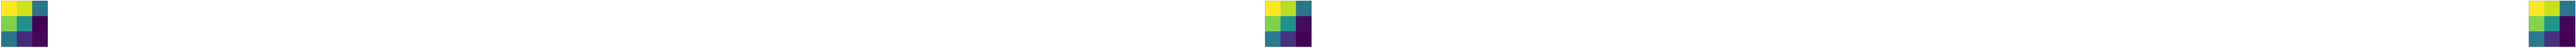

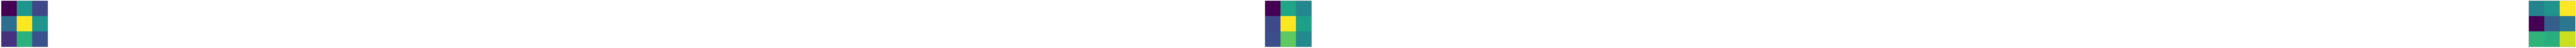

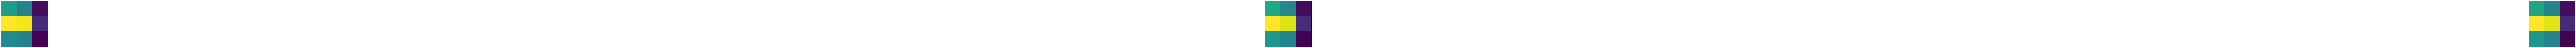

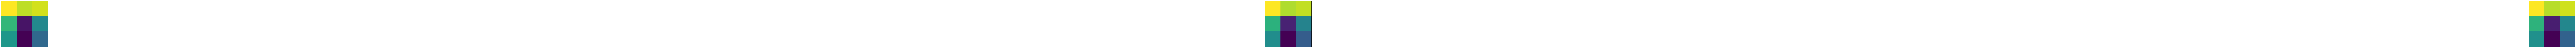

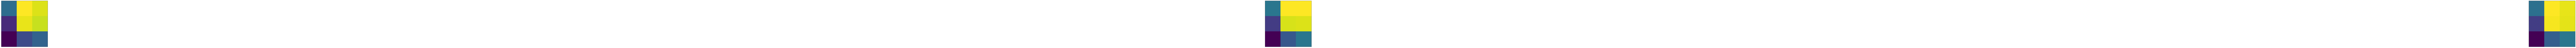

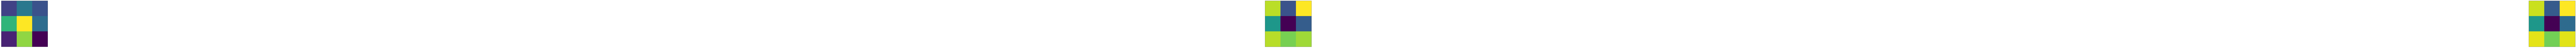

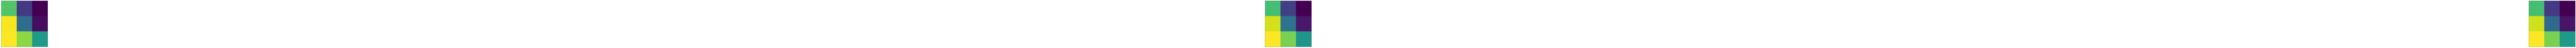

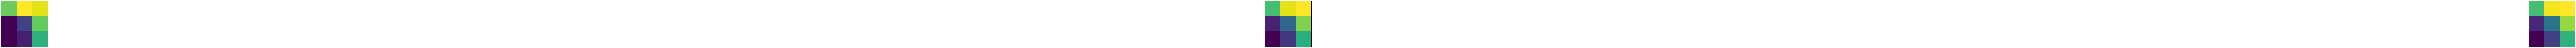

In [ ]:
#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
       
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        print(layer.name, filters.shape)
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            fig, ax = plt.subplots(figsize=(550, 550))
            for j in range(filters.shape[0]):
    
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt   )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
           
        plt.show()

In [33]:
img_path='bird1.png' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

ValueError: in user code:

    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Karnan\.conda\envs\gpu\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_4: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150, 3)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


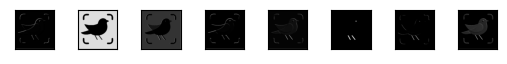

In [27]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import  img_to_array 
from matplotlib import pyplot
from numpy import expand_dims

model = VGG16()

model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

img = load_img('bird1.png', target_size=(224, 224))

img = img_to_array(img)

img = expand_dims(img, axis=0)

img = preprocess_input(img)




feature_maps = model.predict(img)

square = 8
ix = 1
for _ in range(square):

 ax = pyplot.subplot(square, square, ix)
 ax.set_xticks([])
 ax.set_yticks([])

 pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
 ix += 1

pyplot.show()

In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

img = 

feature_maps = model.predict(img)

square = 8
ix = 1
for _ in range(square):

 ax = pyplot.subplot(square, square, ix)
 ax.set_xticks([])
 ax.set_yticks([])

 pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
 ix += 1

pyplot.show()